##  Modeling the fluorescence intensity of mutant GFP molecules
Dan Cox 11/21/21 dancox284@gmail.com

The task is to build a model that predicts the fluorescence intensity of GFP molecules based on their amino acid sequence. The data are from Sarkisyan, K., Bolotin, D., Meer, M. et al. Local fitness landscape of the green fluorescent protein. Nature 533, 397–401 (2016). They consist of the sequences of 49,129 GFP molecules generated by random mutagenesis and measurements of their fluorescence intensities.

## Table of Contents

* [Imports](#Imports)
* [Exploratory Data Analysis](#Exploratory-data-analysis)
    * [How many sequences and how long?](#How-many-sequences-and-how-long?)
    * [Where are the sequences most variable?](#Where-are-the-sequences-most-variable?)
    * [What does the distribution of the brightnesses look like?](#What-does-the-distribution-of-brightnesses-look-like?)
* [Modeling, predicting brightness from amino acid sequence](#Modeling,-predicting-brightness-from-amino-acid-sequence)
    * [Creating train, validation and test sets stratified on 3 brightness levels (0-0.02, 0.02-0.5, 0.5-1.0)](#Creating-train,-validation-and-test-sets-stratified-on-3-brightness-levels-(0-0.02,-0.02-0.5,-0.5-1.0))
    * [Making some utilities for data conversions from amino acids to integers ](#Making-some-utilities-for-data-conversions-from-amino-acids-to-integers )
    * [Converting sequences from letters to integers](#Converting-sequences-from-letters-to-integers)
    * [Representing data as one-hot encoded vectors first.](#Representing-data-as-one-hot-encoded-vectors-first.)
    * [Creating a baseline ridge regression model](#Creating-a-baseline-ridge-regression-model)
    * [Creating a XGboost regression model](#Creating-a-XGboost-regression-model)
    * [Neural network regression modeling](#Neural-network-regression-modeling)
        * [Trying a neural net with one_hot encoded input sequence data](#Trying-a-neural-net-with-one_hot-encoded-input-sequence-data)
        * [Using a grid search to optimize the neural net](#Using-a-grid-search-to-optimize-the-neural-net)
        * [Trying a neural network with an embedding layer](#Trying-a-neural-network-with-an-embedding-layer)
        * [Adding inputs to the neural network indicating hydrophobicity and amino-acid volume](#Adding-inputs-to-the-neural-network-indicating-hydrophobicity-and-amino-acid-volume)
    * [Two-stage classification then regression predicting](#Two-stage-classification-then-regression-predicting)
        * [Building a binary classifier neural network to identify dead GFP](#Building-a-binary-classifier-neural-network-to-identify-dead-GFP)
        * [Building a new regression model fitted to just live GFP (fluo >0.02)](#Building-a-new-regression-model-fitted-to-just-live-GFP-(fluo->0.02))
        * [Testing the two-stage approach](#Testing-the-two-stage-approach)     
* [Final Conclusion](#Final-Conclusion)
    * [Summary Results Table](#Summary-Results-Table)
        




In [ ]:
import os
# Get
os.getcwd()
# Change
os.chdir('/Users/dcox/Dropbox')

In [ ]:
# What was the age distribution among passengers in the Titanic?
import seaborn as sns
sns.set(color_codes=True)
f, ax = plt.subplots(1,1, figsize=(8, 3))
ax = sns.distplot(titanic.age, kde=False, bins=20)
ax.set(xlim=(0, 90))
ax.set_ylabel('counts')
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)
mod = KNeighborsRegressor(n_neighbors=10)
mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)
r2_score(y_test, y_pred)

## Imports

In [1157]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings
warnings.simplefilter(action='ignore', category=Warning)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, KFold

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model

## Exploratory data analysis

### How many sequences and how long?

In [526]:
# Read in and look at data
df= pd.read_csv('gfp.csv')
df.head()

,Sequence,Fluorescence
0,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.872667
1,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.102247
2,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.936593
3,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGGATCGKLTLKF...,0.905209
4,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.139265


In [527]:
# Check length
df.shape

(49129, 2)

In [528]:
# Checking to see if all sequences are the same length
set([len(seq) for seq in df.Sequence])

{238}

#### Conclusions
* There are 49129 sequences
* They are all the same length, 238 AA

### Where are the sequences most variable?

In [529]:
# Converting sequence strings to lists
df_as_list = df.copy()
df_as_list['Sequence'] = df_as_list['Sequence'].map(lambda x: list(x))

In [530]:
# Giving each position its own columnn in the dataframe
df_sequences = pd.DataFrame(df_as_list['Sequence'].to_list())
df_sequences.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237
0,M,S,K,G,E,E,L,F,T,G,V,V,P,I,L,V,E,L,D,G,D,V,N,G,H,K,F,S,V,S,G,E,G,E,G,D,A,T,Y,G,K,L,T,L,K,F,I,C,T,T,...,G,D,G,P,V,L,L,P,D,N,H,Y,L,S,T,Q,S,A,L,S,K,D,P,N,E,K,R,D,H,M,V,L,L,E,F,V,T,A,A,G,I,T,H,G,M,D,E,L,Y,K
1,M,S,K,G,E,E,L,F,T,G,V,V,P,I,L,V,E,L,D,G,D,V,N,G,H,K,F,S,V,S,G,E,G,E,G,D,A,T,Y,G,K,L,T,L,K,F,I,C,T,T,...,G,D,G,P,V,L,L,P,D,N,H,Y,L,S,T,Q,S,A,L,S,K,D,P,N,G,K,R,D,H,M,V,L,L,E,F,V,T,A,A,G,I,T,H,G,M,D,E,L,Y,K
2,M,S,K,G,E,E,L,F,T,G,V,V,P,I,L,V,E,L,D,G,D,V,N,G,H,K,F,S,V,S,G,E,G,E,G,D,A,T,Y,G,K,L,T,L,K,F,I,C,T,T,...,G,D,G,P,V,L,L,P,D,N,H,Y,L,S,T,Q,S,A,L,S,K,D,P,N,E,K,R,D,H,M,V,L,L,E,F,V,T,A,A,G,I,T,H,G,M,D,E,L,Y,K
3,M,S,K,G,E,E,L,F,T,G,V,V,P,I,L,V,E,L,D,G,D,V,N,G,H,K,F,S,V,S,G,E,G,E,G,G,A,T,C,G,K,L,T,L,K,F,I,C,T,T,...,G,D,G,P,V,L,L,P,D,N,H,Y,L,S,T,Q,S,A,L,S,K,D,P,N,E,K,R,D,H,M,V,L,L,E,F,V,T,A,A,G,I,T,H,G,M,D,E,L,Y,K
4,M,S,K,G,E,E,L,F,T,G,V,V,P,I,L,V,E,L,D,G,D,V,N,G,H,K,F,S,V,S,G,E,G,E,G,D,A,T,Y,G,K,L,T,L,K,F,I,C,T,T,...,G,D,G,P,V,L,L,P,D,N,H,Y,L,S,T,Q,S,A,L,S,K,D,P,N,E,K,R,D,H,M,V,L,L,E,F,V,T,A,A,G,N,T,H,G,M,D,E,L,Y,K


In [531]:
# Counting number of different AA at each position
num_diff_aa = [df_sequences.iloc[:,i].value_counts().count() for i in range(238)]

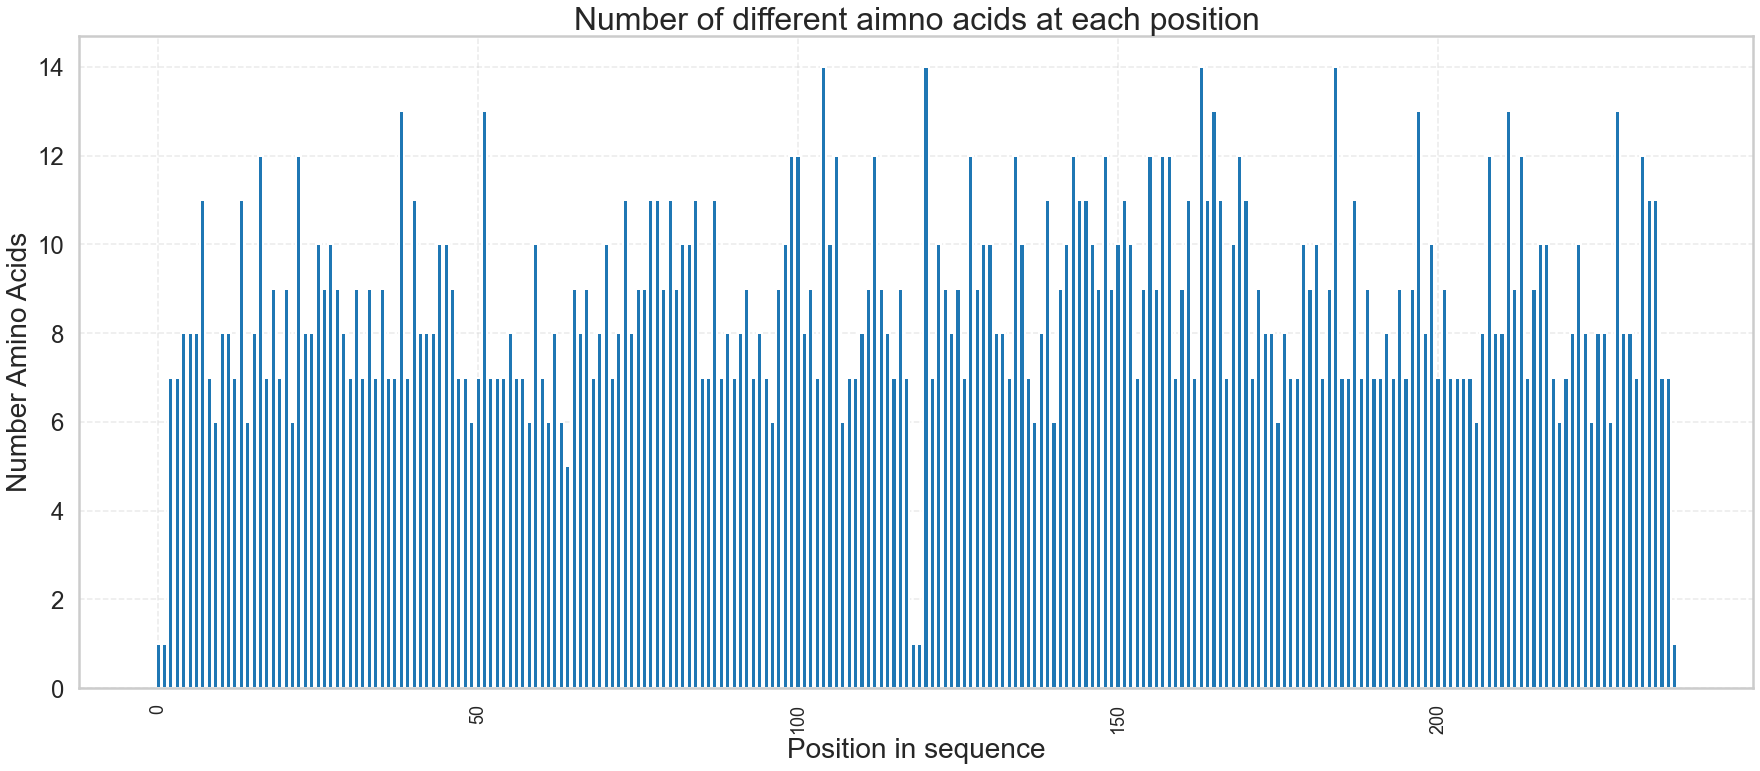

In [532]:
# Plotting number of different AA at each position
plt.figure(figsize = (30, 12))
plt.bar(range(238), num_diff_aa)
plt.xlabel('Position in sequence', fontsize=28)
plt.ylabel('Number Amino Acids', fontsize=28)
plt.yticks(fontsize=24)
#plt.xlim(100, 150)
plt.xticks(fontsize=18, rotation=90)
plt.grid(True, lw=1.5, ls='--', alpha=0.4)
plt.title('Number of different aimno acids at each position', fontsize=32)
plt.show()

#### Conclusion
* There are typically between 6 and 12 different amino acids used at each position across the whole sequence.
* Some positions have as many as 14 different AAs.
* Five positions have only 1 AA. (0, 1, 118, 119, 238).
* Apart from the start methionine, these may be essential for proper folding or function.

### What does the distribution of brightnesses look like?

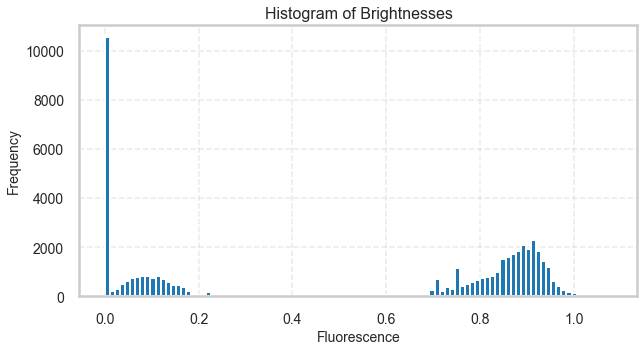

In [533]:
# Looking at fluorescence levels of the GFPs
plt.figure(figsize = (10, 5))
df.Fluorescence.hist(bins=100)
plt.xlabel('Fluorescence', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
#plt.xlim(0, 0.1)
plt.tick_params(labelsize=14)
plt.grid(True, lw=1.5, ls='--', alpha=0.4)
plt.title('Histogram of Brightnesses', fontsize=16)
plt.show()

#### Conclusion
* The distribution of brightness looks trimodal.
* There appears to many dead GFPs with brightnesses less than 0.02 (~ 20%)
* Then there are some dim ones with brightnesses between 0.02 and 0.3.
* And then there are some bright ones with brightnesses between 0.6 and 1.
* There are very few intermediate-brightness GFPs (Fluo = 0.25 to 0.6)
* For any model meant to predict on all these types of sequences, it will be important that each group is represented similarly in the training, validation and test data sets.

## Modeling, predicting brightness from amino acid sequence

### Creating train, validation and test sets stratified on 3 brightness levels (0-0.02, 0.02-0.5, 0.5-1.0)
For the modeling to follow three data sets are created here: train, validation and test.
* The train set will be used to train the models.
* The validation set will be used to refine the models.
* The test set will be used only for final evaluation of the models after refinement.
* The code below creates these sets stratifying on brightness level (dead , low, high)

In [535]:
# Adding a column to the dataframe to indicate brightness level(dead, low, high)
idx_dead = df_as_list.index[(df_as_list['Fluorescence'] <= 0.02)]
idx_low = df_as_list.index[(df_as_list['Fluorescence'] > 0.02) & (df_as_list['Fluorescence'] <= 0.5)]
idx_high = df_as_list.index[(df_as_list['Fluorescence'] > 0.5)]
df_as_list['Brightness_level'] = list(range(49129))
df_as_list['Brightness_level'][idx_dead] = 'dead'
df_as_list['Brightness_level'][idx_low] = 'low'
df_as_list['Brightness_level'][idx_high] = 'high'

In [536]:
# Creating Train and test sets (80/20 split) stratified on brightness level
X_train, X_test, y_train, y_test = train_test_split(df_as_list['Sequence'].values,df_as_list['Fluorescence'].values, test_size=0.20, stratify=df_as_list['Brightness_level'], random_state=1)

In [537]:
# Creating Train and Validation sets from the train set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=1)

### Making some utilities for data conversions from amino acids to integers 

In [552]:
# List of amino_acid codes
amino_acids = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'V', 'Y']

In [553]:
# Conversion dictionarys, amino acid to integer and integer to amino acid
aa_to_idx = {aa:s for aa, s, in zip(amino_acids, list(range(20)))}
idx_to_aa = {s:aa for aa, s, in zip(amino_acids, list(range(20)))}

In [834]:
# Amino acid to integer for single sequence
def convert_seq_aa_to_int(seq, conversion_dict_aa_to_idx):
    return np.array([conversion_dict_aa_to_idx[s] for s in seq])

# Amino acid to integer for list of sequences 
def convert_seq_list_aa_to_int(seq_list, conversion_dict_aa_to_idx):
    return np.array([convert_seq_aa_to_int(seq, conversion_dict_aa_to_idx) for seq in seq_list])

# Integer to amino acid for single sequence
def convert_seq_int_to_aa(seq, conversion_dict_idx_to_aa):
    return np.array([conversion_dict_idx_to_aa[s] for s in seq])

# Integer to amino acid for list of sequences
def convert_seq_list_int_to_aa(seq_list, conversion_dict_idx_to_aa):
    return np.array([convert_seq_int_to_aa(seq, conversion_dict_idx_to_aa) for seq in seq_list])

### Converting sequences from letters to integers

In [556]:
# Converting X_train, X_valid and X_test to integer representations
X_train_int = convert_seq_list_aa_to_int(X_train, aa_to_idx)
X_valid_int = convert_seq_list_aa_to_int(X_valid, aa_to_idx)
X_test_int = convert_seq_list_aa_to_int(X_test, aa_to_idx)

In [562]:
# Looking at top of X_train 
X_train_int[:2]

array([[12, 15, 11,  7,  5,  5, 10, 13, 16,  7, 18, 18, 14,  9, 10, 18,
         5, 10,  3,  7,  3, 18,  2,  7,  8, 11, 13, 15, 18, 15,  7,  5,
         7,  5,  7,  3,  0, 16, 19,  7, 11, 10, 16, 10, 11, 13,  9,  4,
        16, 16,  7, 11, 10, 14, 18, 14, 17, 14, 16, 10, 18, 16, 16, 10,
        15, 19,  7, 18,  6,  4, 13, 15,  1, 19, 14,  3,  8, 12, 11,  6,
         8,  3, 13, 13, 11, 15,  0, 12, 14,  5,  7, 19, 18,  6,  5,  1,
        16,  9, 13, 13, 11,  3,  3,  7,  2, 19, 11, 16,  1,  0,  5, 18,
        11, 13,  5,  7,  3, 16, 10, 18,  2,  1,  9,  5, 10, 11,  7,  9,
         3, 13, 11,  5,  3,  7,  2,  9, 10,  7,  8, 11, 10,  5, 19,  2,
        19,  2, 15,  8,  2, 18, 19,  9, 12,  0,  3, 11,  6, 11,  2,  7,
         9, 11, 18,  2, 15, 11,  9,  1,  8,  2,  9,  5,  3,  7, 15, 18,
         6, 10,  0,  3,  8, 19,  6,  6,  2, 16, 14,  9,  7,  3,  7, 14,
        18, 10, 10, 14,  3,  2,  8, 19, 10, 15, 16,  6, 15,  0, 10, 15,
        11,  3, 14,  2,  5, 11,  1,  3,  8, 12, 18, 10, 10,  5, 

### Representing data as one-hot encoded vectors first.
* Since the data is catgeorical, it must be converted to some numerical representation. The simplest approach would be to represent each amino acid as a 20 dimensional one-hot encoded vector. Alternatively, some more dense embedding might be used.


* In the field of natural language processing dense embeddings, such as word2vec, have been critical for recent progress. This is because in NLP the vocabularies are large such that one-hot encoded vectors for each word become untenable. Further, word embeddings have been found that carry information about word meaning and usage. Embeddings for similar words are closer to each other in euclidian distance than are embeddings for words with unrelated meanings and usage. 


* Here, for amino acids, it seems to me that the need for such embeddings is much less, as the size of the volcabulary is only 20 amino acids, and the range of possible variation in amino-acid character is also far less. Still, one could imagine amino-acid embeddings that capture such properties as hydrophobicity or side-chain volume, or perhaps tendency to be associated with certain secondary structures, so it may be that such embeddings would be useful. 


* I will first work with one-hot encoded vectors, and then after seeing how well they work, I will trying using a neural network with an embedding layer that learns embeddings for each amino acid. 

In [563]:
# Converting X_train, X_valid and X_test to flat one_hot encoded vectors dim = (-1, 4760)
X_train_hot = to_categorical(X_train_int)
X_train_hot = X_train_hot.reshape(-1, 238*20)
X_valid_hot = to_categorical(X_valid_int)
X_valid_hot = X_valid_hot.reshape(-1, 238*20)
X_test_hot = to_categorical(X_test_int)
X_test_hot = X_test_hot.reshape(-1, 238*20)

In [564]:
# reshaping y data for sklearn
y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

### Creating a baseline ridge regression model
* Here I create a baseline linear regression model with L2 regularization whose performance will be compared to other models below.
* The model is trained on the train data using 5 fold crossvalidation and then finally tested on the test data.

#### Metrics
For the modeling below I will report 3 metrics:
* MSE becasue it is the loss function and the maximum liklihood estimator for the parameters.
* rMSE becasue it gives a more intuitive feel for how far off the model's predictions are.
* r^2 because it indicates how much of the variance in brightness is accounted for by the model.

#### Some helper functions

In [569]:
# Function for plotting model predicted vs true brightnesses
def plot_model_prediction_vs_true(y_test, preds_test, title='Regression on test data'):
    fs=14
    plt.figure(figsize = (10, 5))
    plt.scatter(y_test, preds_test, alpha=0.5, s=10)
    plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), c='red', alpha = 0.6, ls='--')
    plt.plot(range(0 ,1), range(0 ,1), c='red')
    plt.xlabel('True fluorescence', fontsize = fs)
    plt.ylabel('Predicted fluorescence',fontsize = fs)
    plt.grid(True, lw=1.5, ls='--', alpha=0.75)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(title,fontsize = 16)
    plt.show()

# Function for printing model scores
def print_model_scores(y_train, preds_train, y_test, preds_test):
    print(f'r^2 score on train set is {r2_score(y_train, preds_train):.4f}')
    print(f'r^2 score on test set is {r2_score(y_test, preds_test):.4f}')
    print(f'MSE on train set is {mean_squared_error(y_train, preds_train):.4f}')
    print(f'MSE on test set is {mean_squared_error(y_test, preds_test):.4f}')
    print(f'rMSE on train set is {(mean_squared_error(y_train, preds_train))**0.5:.4f}')
    print(f'rMSE on test set is {(mean_squared_error(y_test, preds_test))**0.5:.4f}')

#### Creating a Ridge model

In [570]:
# Creating a ridge regression model and crossvalidating for best alpha
from sklearn.linear_model import RidgeCV
mod = RidgeCV(alphas=[1e-1, 1, 1e1, 3e-1], cv=5)
mod.fit(X_train_hot, y_train)
preds_train = mod.predict(X_train_hot)
preds_test = mod.predict(X_test_hot)
print(f'Best alpha = {mod.alpha_}')
print_model_scores(y_train, preds_train, y_test, preds_test)

Best alpha = 10.0
r^2 score on train set is 0.7181
r^2 score on test set is 0.6987
MSE on train set is 0.0459
MSE on test set is 0.0491
rMSE on train set is 0.2142
rMSE on test set is 0.2215


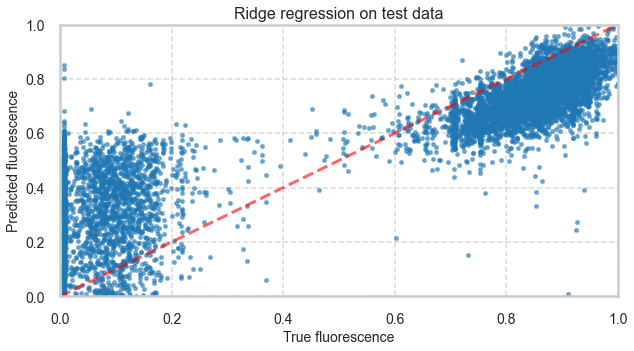

In [571]:
plot_model_prediction_vs_true(y_test, preds_test, title = 'Ridge regression on test data')

#### Conclusion
* The MSE on the test data is 0.049, rMSE is 0.221.
* The r^2 score indicates about 70% of the variance in brightness is accounted for by the model.
* The MSEs on the train and test sets are similar, suggesting that the model is not overfitting much.
* Brightness is generally under predicted at high fluorescence and overpredicted at low fluorescence.
* Perhaps a non-linear model would work better.

### Creating a XGboost regression model
Here I try predicting brightness with an XGboost model, a gradient-boosted ensemble tree-based approach.
I choose to use this model because:
* It is a non-linear model, and the paper by Sarkisyan, K et al, indicates that there is a good deal of epistasis in the effects of mutations on brightness (epistasis meaning non-linear effects of mutations). Thus, a non-linear model may perform better. 

* XGboost models are known to have good performance on many tasks and to deal well with sparse data.

* If it does work well, through the models importance scores, its results are much more interpretable than those of a neural network.

r^2 score on train set is 0.7834
r^2 score on test set is 0.7062
MSE on train set is 0.0352
MSE on test set is 0.0479
rMSE on train set is 0.1877
rMSE on test set is 0.2188


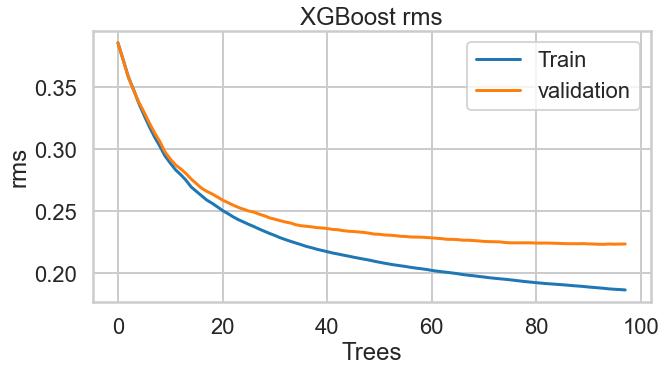

In [572]:
# Creating a XGboost regression model validating on X_valid, final testing on X_test
from xgboost import XGBRegressor
XG = XGBRegressor(objective='reg:squarederror',
                  n_estimators=200,
                  min_child_weight=1,
                  max_depth=6,
                  subsample=0.7,
                  colsample_bytree=0.5,
                  learning_rate=0.5, 
                 verbosity=0)

eval_set = [(X_train_hot, y_train), (X_valid_hot, y_valid)]
XG.fit(X_train_hot, y_train, eval_metric="rmse", early_stopping_rounds=5, eval_set=eval_set,
       verbose=False)

# Make predictions and evaluate
preds_train = XG.predict(X_train_hot)
preds_test = XG.predict(X_test_hot)
print_model_scores(y_train, preds_train, y_test, preds_test)
results = XG.evals_result()
epochs = len(results['validation_0']['rmse'])

# Plot progress over epochs
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x_axis = range(0, epochs)
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='validation')
ax.legend()
ax.set_ylabel('rms')
ax.set_xlabel('Trees')
ax.set_title('XGBoost rms')
plt.show()

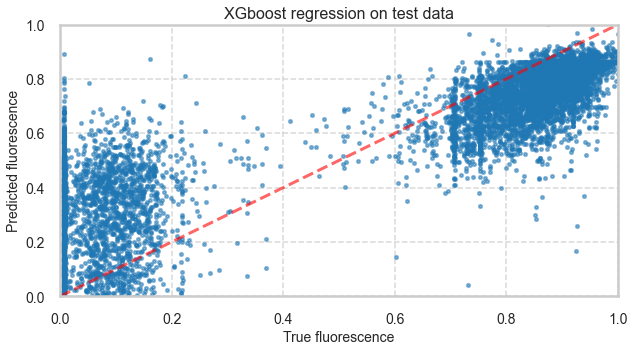

In [573]:
plot_model_prediction_vs_true(y_test, preds_test, title = 'XGboost regression on test data')

#### Conclusion
* Surprisingly, The MSE and r^2 scores are about the same as they were with the Ridge model.
* (Ridge: r^2 0.6987, MSE 0.0491, XGboost: r^2 0.7062, MSE 0.0479)
* The plot of train and validation losses suggests that the model is overfitting but not too badly.
* Again, brightness is generally under predicted at high fluorescence and overpredicted at low fluorescence.
* Perhaps this model could do better, if further optimized. I have tried varying max-depth and learning rate with no further improvement.
* Perhaps I could find better paramters, but I will try a neural net first, as it may be more expressive.

## Neural network regression modeling
Here I build a feedforward neural network for regression with keras on tensorflow, predicting brightness from amino acid sequence.

In [574]:
# Function for Building a regression Neural Network
def build_nn_model(num_hidden, width_hidden, drop_rate=drop_rate, learning_rate=learning_rate):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(width_hidden, activation = 'relu', input_shape=(20*238,)))
    for i in range(num_hidden-1):
        model.add(tf.keras.layers.Dense(width_hidden, activation = 'relu'))
        model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics = ['mse'])
    model.summary()                               
    return model    

In [575]:
# Function for Plotting losses
def plot_losses():
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('model loss', fontsize = 14)
    ax.set_ylabel('Loss', fontsize = 14)
    ax.set_xlabel('Epoch', fontsize = 14)
    ax.tick_params(labelsize = 14)
    ax.legend(['train', 'val'], loc='best', fontsize = 12)
    ax.grid(True, lw = 1.5, ls = '--', color='gray', alpha = 0.3)

### Trying a neural net with one_hot encoded input sequence data
* 3 hidden layers, 100 neurons per hidden layer

In [576]:
# Defining Model Hyperparameters
num_hidden = 3
width_hidden = 100
drop_rate = 0.1
batch_size = 32
epochs = 10
learning_rate = 0.001
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, verbose=1)]

# Building Neural Net
model = build_nn_model(num_hidden, width_hidden, drop_rate, learning_rate)

# Fitting the NN to the training data, using the valid data for validation
history = model.fit(X_train_hot, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=(X_valid_hot, y_valid),
          shuffle=True)

Model: "sequential_380"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1845 (Dense)           (None, 100)               476100    
_________________________________________________________________
dense_1846 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1077 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_1847 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1078 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_1848 (Dense)           (None, 1)                 101       
Total params: 496,401
Trainable params: 496,401
Non-trainable params: 0
______________________________________________

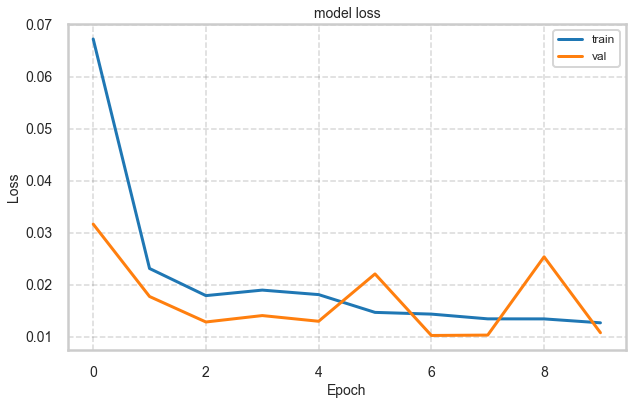

In [577]:
# Plotting losses
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss', fontsize = 14)
ax.set_ylabel('Loss', fontsize = 14)
ax.set_xlabel('Epoch', fontsize = 14)
ax.tick_params(labelsize = 14)
ax.legend(['train', 'val'], loc='best', fontsize = 12)
ax.grid(True, lw = 1.5, ls = '--', color='gray', alpha = 0.3)

In [578]:
preds_train = model.predict(X_train_hot)
preds_test = model.predict(X_test_hot)
print_model_scores(y_train, preds_train, y_test, preds_test)

r^2 score on train set is 0.9553
r^2 score on test set is 0.9429
MSE on train set is 0.0073
MSE on test set is 0.0093
rMSE on train set is 0.0852
rMSE on test set is 0.0964


#### Conclusion
* The neural net is yielding much better MSE and r^2 scores than the linear model or the XGboost model.
* r^2 on test = (Ridge: 0.699, XGboost: 0.706, NN: 0.943)
* MSE on test = (Ridge: 0.0491, XGboost: 0.0479, NN: 0.0093)
* rMSE on test = (Ridge: 0.221, XGboost: 0.219, NN: 0.096)
* I will now try to optimize it further with a grid search.

### Using a grid search to optimize the neural net
The following parameters will be optimized
* The number of hidden layers
* The number of units in each hidden layer
* The dropout rate

#### Grid search 

In [579]:
# Create model for Grid Search
model = KerasRegressor(build_fn = build_nn_model, verbose = 0, batch_size = 32, epochs = 10)

# grid search parameters
num_hidden = [3,4,5]
width_hidden = [20, 50, 100, 200]
drop_rate = [0.1, 0.2, 0.3]
param_dict = dict(num_hidden = num_hidden, width_hidden = width_hidden, drop_rate = drop_rate)

# Build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_dict, cv = KFold(), scoring='neg_mean_squared_error',    verbose = 10)
grid_result = grid.fit(X_train_hot,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START drop_rate=0.1, num_hidden=3, width_hidden=20...............
Model: "sequential_381"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1849 (Dense)           (None, 20)                95220     
_________________________________________________________________
dense_1850 (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1079 (Dropout)       (None, 20)                0         
_________________________________________________________________
dense_1851 (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1080 (Dropout)       (None, 20)                0         
_________________________________________________________________
dense_1852 (Dense)           (None, 1)   

[CV 2/5; 2/36] END drop_rate=0.1, num_hidden=3, width_hidden=50; total time=   7.1s
[CV 3/5; 2/36] START drop_rate=0.1, num_hidden=3, width_hidden=50...............
Model: "sequential_388"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1877 (Dense)           (None, 50)                238050    
_________________________________________________________________
dense_1878 (Dense)           (None, 50)                2550      
_________________________________________________________________
dropout_1093 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_1879 (Dense)           (None, 50)                2550      
_________________________________________________________________
dropout_1094 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_1880 (Dense) 

[CV 4/5; 3/36] END drop_rate=0.1, num_hidden=3, width_hidden=100; total time=  10.9s
[CV 5/5; 3/36] START drop_rate=0.1, num_hidden=3, width_hidden=100..............
Model: "sequential_395"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1905 (Dense)           (None, 100)               476100    
_________________________________________________________________
dense_1906 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1107 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_1907 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1108 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_1908 (Dense)

[CV 1/5; 5/36] END drop_rate=0.1, num_hidden=4, width_hidden=20; total time=   5.1s
[CV 2/5; 5/36] START drop_rate=0.1, num_hidden=4, width_hidden=20...............
Model: "sequential_402"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1934 (Dense)           (None, 20)                95220     
_________________________________________________________________
dense_1935 (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1122 (Dropout)       (None, 20)                0         
_________________________________________________________________
dense_1936 (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1123 (Dropout)       (None, 20)                0         
_________________________________________________________________
dense_1937 (Dense) 

[CV 2/5; 6/36] END drop_rate=0.1, num_hidden=4, width_hidden=50; total time=   7.2s
[CV 3/5; 6/36] START drop_rate=0.1, num_hidden=4, width_hidden=50...............
Model: "sequential_408"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1964 (Dense)           (None, 50)                238050    
_________________________________________________________________
dense_1965 (Dense)           (None, 50)                2550      
_________________________________________________________________
dropout_1140 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_1966 (Dense)           (None, 50)                2550      
_________________________________________________________________
dropout_1141 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_1967 (Dense) 

[CV 3/5; 7/36] END drop_rate=0.1, num_hidden=4, width_hidden=100; total time=  11.8s
[CV 4/5; 7/36] START drop_rate=0.1, num_hidden=4, width_hidden=100..............
Model: "sequential_414"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1994 (Dense)           (None, 100)               476100    
_________________________________________________________________
dense_1995 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1158 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_1996 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1159 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_1997 (Dense)

[CV 4/5; 8/36] END drop_rate=0.1, num_hidden=4, width_hidden=200; total time=  21.0s
[CV 5/5; 8/36] START drop_rate=0.1, num_hidden=4, width_hidden=200..............
Model: "sequential_420"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2024 (Dense)           (None, 200)               952200    
_________________________________________________________________
dense_2025 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1176 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2026 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1177 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2027 (Dense)

[CV 4/5; 9/36] END drop_rate=0.1, num_hidden=5, width_hidden=20; total time=   5.2s
[CV 5/5; 9/36] START drop_rate=0.1, num_hidden=5, width_hidden=20...............
Model: "sequential_425"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2053 (Dense)           (None, 20)                95220     
_________________________________________________________________
dense_2054 (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1195 (Dropout)       (None, 20)                0         
_________________________________________________________________
dense_2055 (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1196 (Dropout)       (None, 20)                0         
_________________________________________________________________
dense_2056 (Dense) 

[CV 4/5; 10/36] END drop_rate=0.1, num_hidden=5, width_hidden=50; total time=   8.4s
[CV 5/5; 10/36] START drop_rate=0.1, num_hidden=5, width_hidden=50..............
Model: "sequential_430"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2083 (Dense)           (None, 50)                238050    
_________________________________________________________________
dense_2084 (Dense)           (None, 50)                2550      
_________________________________________________________________
dropout_1215 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_2085 (Dense)           (None, 50)                2550      
_________________________________________________________________
dropout_1216 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_2086 (Dense)

[CV 4/5; 11/36] END drop_rate=0.1, num_hidden=5, width_hidden=100; total time=  11.5s
[CV 5/5; 11/36] START drop_rate=0.1, num_hidden=5, width_hidden=100.............
Model: "sequential_435"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2113 (Dense)           (None, 100)               476100    
_________________________________________________________________
dense_2114 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1235 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_2115 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1236 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_2116 (Dense

[CV 4/5; 12/36] END drop_rate=0.1, num_hidden=5, width_hidden=200; total time=  21.4s
[CV 5/5; 12/36] START drop_rate=0.1, num_hidden=5, width_hidden=200.............
Model: "sequential_440"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2143 (Dense)           (None, 200)               952200    
_________________________________________________________________
dense_2144 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1255 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2145 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1256 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2146 (Dense

[CV 5/5; 13/36] END drop_rate=0.2, num_hidden=3, width_hidden=20; total time=   4.7s
[CV 1/5; 14/36] START drop_rate=0.2, num_hidden=3, width_hidden=50..............
Model: "sequential_446"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2169 (Dense)           (None, 50)                238050    
_________________________________________________________________
dense_2170 (Dense)           (None, 50)                2550      
_________________________________________________________________
dropout_1269 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_2171 (Dense)           (None, 50)                2550      
_________________________________________________________________
dropout_1270 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_2172 (Dense)

[CV 2/5; 15/36] END drop_rate=0.2, num_hidden=3, width_hidden=100; total time=  11.4s
[CV 3/5; 15/36] START drop_rate=0.2, num_hidden=3, width_hidden=100.............
Model: "sequential_453"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2197 (Dense)           (None, 100)               476100    
_________________________________________________________________
dense_2198 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1283 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_2199 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1284 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_2200 (Dense

[CV 4/5; 16/36] END drop_rate=0.2, num_hidden=3, width_hidden=200; total time=  19.5s
[CV 5/5; 16/36] START drop_rate=0.2, num_hidden=3, width_hidden=200.............
Model: "sequential_460"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2225 (Dense)           (None, 200)               952200    
_________________________________________________________________
dense_2226 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1297 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2227 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1298 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2228 (Dense

[CV 5/5; 17/36] END drop_rate=0.2, num_hidden=4, width_hidden=20; total time=   5.0s
[CV 1/5; 18/36] START drop_rate=0.2, num_hidden=4, width_hidden=50..............
Model: "sequential_466"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2254 (Dense)           (None, 50)                238050    
_________________________________________________________________
dense_2255 (Dense)           (None, 50)                2550      
_________________________________________________________________
dropout_1314 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_2256 (Dense)           (None, 50)                2550      
_________________________________________________________________
dropout_1315 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_2257 (Dense)

[CV 1/5; 19/36] END drop_rate=0.2, num_hidden=4, width_hidden=100; total time=  11.4s
[CV 2/5; 19/36] START drop_rate=0.2, num_hidden=4, width_hidden=100.............
Model: "sequential_472"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2284 (Dense)           (None, 100)               476100    
_________________________________________________________________
dense_2285 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1332 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_2286 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1333 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_2287 (Dense

[CV 2/5; 20/36] END drop_rate=0.2, num_hidden=4, width_hidden=200; total time=  20.8s
[CV 3/5; 20/36] START drop_rate=0.2, num_hidden=4, width_hidden=200.............
Model: "sequential_478"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2314 (Dense)           (None, 200)               952200    
_________________________________________________________________
dense_2315 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1350 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2316 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1351 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2317 (Dense

[CV 2/5; 21/36] END drop_rate=0.2, num_hidden=5, width_hidden=20; total time=   5.3s
[CV 3/5; 21/36] START drop_rate=0.2, num_hidden=5, width_hidden=20..............
Model: "sequential_483"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2341 (Dense)           (None, 20)                95220     
_________________________________________________________________
dense_2342 (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1367 (Dropout)       (None, 20)                0         
_________________________________________________________________
dense_2343 (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1368 (Dropout)       (None, 20)                0         
_________________________________________________________________
dense_2344 (Dense)

[CV 2/5; 22/36] END drop_rate=0.2, num_hidden=5, width_hidden=50; total time=  10.6s
[CV 3/5; 22/36] START drop_rate=0.2, num_hidden=5, width_hidden=50..............
Model: "sequential_488"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2371 (Dense)           (None, 50)                238050    
_________________________________________________________________
dense_2372 (Dense)           (None, 50)                2550      
_________________________________________________________________
dropout_1387 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_2373 (Dense)           (None, 50)                2550      
_________________________________________________________________
dropout_1388 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_2374 (Dense)

[CV 2/5; 23/36] END drop_rate=0.2, num_hidden=5, width_hidden=100; total time=  12.5s
[CV 3/5; 23/36] START drop_rate=0.2, num_hidden=5, width_hidden=100.............
Model: "sequential_493"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2401 (Dense)           (None, 100)               476100    
_________________________________________________________________
dense_2402 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1407 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_2403 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1408 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_2404 (Dense

[CV 2/5; 24/36] END drop_rate=0.2, num_hidden=5, width_hidden=200; total time=  22.9s
[CV 3/5; 24/36] START drop_rate=0.2, num_hidden=5, width_hidden=200.............
Model: "sequential_498"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2431 (Dense)           (None, 200)               952200    
_________________________________________________________________
dense_2432 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1427 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2433 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1428 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2434 (Dense

[CV 3/5; 25/36] END drop_rate=0.3, num_hidden=3, width_hidden=20; total time=   5.0s
[CV 4/5; 25/36] START drop_rate=0.3, num_hidden=3, width_hidden=20..............
Model: "sequential_504"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2461 (Dense)           (None, 20)                95220     
_________________________________________________________________
dense_2462 (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1445 (Dropout)       (None, 20)                0         
_________________________________________________________________
dense_2463 (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1446 (Dropout)       (None, 20)                0         
_________________________________________________________________
dense_2464 (Dense)

[CV 5/5; 26/36] END drop_rate=0.3, num_hidden=3, width_hidden=50; total time=   8.0s
[CV 1/5; 27/36] START drop_rate=0.3, num_hidden=3, width_hidden=100.............
Model: "sequential_511"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2489 (Dense)           (None, 100)               476100    
_________________________________________________________________
dense_2490 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1459 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_2491 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1460 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_2492 (Dense)

[CV 2/5; 28/36] END drop_rate=0.3, num_hidden=3, width_hidden=200; total time=  19.4s
[CV 3/5; 28/36] START drop_rate=0.3, num_hidden=3, width_hidden=200.............
Model: "sequential_518"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2517 (Dense)           (None, 200)               952200    
_________________________________________________________________
dense_2518 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1473 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2519 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1474 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2520 (Dense

[CV 3/5; 29/36] END drop_rate=0.3, num_hidden=4, width_hidden=20; total time=   5.2s
[CV 4/5; 29/36] START drop_rate=0.3, num_hidden=4, width_hidden=20..............
Model: "sequential_524"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2544 (Dense)           (None, 20)                95220     
_________________________________________________________________
dense_2545 (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1488 (Dropout)       (None, 20)                0         
_________________________________________________________________
dense_2546 (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1489 (Dropout)       (None, 20)                0         
_________________________________________________________________
dense_2547 (Dense)

[CV 4/5; 30/36] END drop_rate=0.3, num_hidden=4, width_hidden=50; total time=   7.9s
[CV 5/5; 30/36] START drop_rate=0.3, num_hidden=4, width_hidden=50..............
Model: "sequential_530"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2574 (Dense)           (None, 50)                238050    
_________________________________________________________________
dense_2575 (Dense)           (None, 50)                2550      
_________________________________________________________________
dropout_1506 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_2576 (Dense)           (None, 50)                2550      
_________________________________________________________________
dropout_1507 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_2577 (Dense)

[CV 5/5; 31/36] END drop_rate=0.3, num_hidden=4, width_hidden=100; total time=  11.2s
[CV 1/5; 32/36] START drop_rate=0.3, num_hidden=4, width_hidden=200.............
Model: "sequential_536"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2604 (Dense)           (None, 200)               952200    
_________________________________________________________________
dense_2605 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1524 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2606 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1525 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2607 (Dense

[CV 1/5; 33/36] END drop_rate=0.3, num_hidden=5, width_hidden=20; total time=   5.2s
[CV 2/5; 33/36] START drop_rate=0.3, num_hidden=5, width_hidden=20..............
Model: "sequential_542"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2635 (Dense)           (None, 20)                95220     
_________________________________________________________________
dense_2636 (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1543 (Dropout)       (None, 20)                0         
_________________________________________________________________
dense_2637 (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1544 (Dropout)       (None, 20)                0         
_________________________________________________________________
dense_2638 (Dense)

[CV 1/5; 34/36] END drop_rate=0.3, num_hidden=5, width_hidden=50; total time=   7.9s
[CV 2/5; 34/36] START drop_rate=0.3, num_hidden=5, width_hidden=50..............
Model: "sequential_547"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2665 (Dense)           (None, 50)                238050    
_________________________________________________________________
dense_2666 (Dense)           (None, 50)                2550      
_________________________________________________________________
dropout_1563 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_2667 (Dense)           (None, 50)                2550      
_________________________________________________________________
dropout_1564 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_2668 (Dense)

[CV 1/5; 35/36] END drop_rate=0.3, num_hidden=5, width_hidden=100; total time=  11.8s
[CV 2/5; 35/36] START drop_rate=0.3, num_hidden=5, width_hidden=100.............
Model: "sequential_552"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2695 (Dense)           (None, 100)               476100    
_________________________________________________________________
dense_2696 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1583 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_2697 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1584 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_2698 (Dense

[CV 1/5; 36/36] END drop_rate=0.3, num_hidden=5, width_hidden=200; total time=  22.8s
[CV 2/5; 36/36] START drop_rate=0.3, num_hidden=5, width_hidden=200.............
Model: "sequential_557"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2725 (Dense)           (None, 200)               952200    
_________________________________________________________________
dense_2726 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1603 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2727 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1604 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2728 (Dense

#### Results of Grid Search

In [582]:
# # Summarizing the results
print(f'Best : {grid_result.best_score_:.4f} , using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print(' ')
print('mean          stdev        params')
for mean, stdev, param in zip(means, stds, params):
    print(f'{mean:.4f},{stdev:.4f} with: {param}')

Best : -0.0108 , using {'drop_rate': 0.1, 'num_hidden': 3, 'width_hidden': 200}
 
mean          stdev        params
-0.0152,0.0023 with: {'drop_rate': 0.1, 'num_hidden': 3, 'width_hidden': 20}
-0.0131,0.0019 with: {'drop_rate': 0.1, 'num_hidden': 3, 'width_hidden': 50}
-0.0175,0.0080 with: {'drop_rate': 0.1, 'num_hidden': 3, 'width_hidden': 100}
-0.0108,0.0008 with: {'drop_rate': 0.1, 'num_hidden': 3, 'width_hidden': 200}
-0.0145,0.0050 with: {'drop_rate': 0.1, 'num_hidden': 4, 'width_hidden': 20}
-0.0159,0.0107 with: {'drop_rate': 0.1, 'num_hidden': 4, 'width_hidden': 50}
-0.0161,0.0046 with: {'drop_rate': 0.1, 'num_hidden': 4, 'width_hidden': 100}
-0.0165,0.0036 with: {'drop_rate': 0.1, 'num_hidden': 4, 'width_hidden': 200}
-0.0145,0.0018 with: {'drop_rate': 0.1, 'num_hidden': 5, 'width_hidden': 20}
-0.0116,0.0013 with: {'drop_rate': 0.1, 'num_hidden': 5, 'width_hidden': 50}
-0.0202,0.0078 with: {'drop_rate': 0.1, 'num_hidden': 5, 'width_hidden': 100}
-0.0341,0.0329 with: {'drop_rate

#### Conclusions
* The best model according to the search is with the following hyperparameters:
* 3 hidden layer
* 200 neurons each hidden layer
* dropout rate = 0.1

#### Fitting data using a  neural net with the best hyperparameters and saving

In [589]:
# Defining Model Hyperparameters
num_hidden = 3
width_hidden = 200
drop_rate = 0.1
batch_size = 32
epochs = 10
learning_rate = 0.0001

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, verbose=1)]

In [590]:
# Building a Neural Net
model = build_nn_model(num_hidden, width_hidden, drop_rate, learning_rate)  

Model: "sequential_563"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2757 (Dense)           (None, 200)               952200    
_________________________________________________________________
dense_2758 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1623 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2759 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1624 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2760 (Dense)           (None, 1)                 201       
Total params: 1,032,801
Trainable params: 1,032,801
Non-trainable params: 0
__________________________________________

In [591]:
# Fitting the NN to the training data, using the valid data for validation
history = model.fit(X_train_hot, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=(X_valid_hot, y_valid),
          shuffle=True)

Epoch 1/10
983/983 [==============================] - 3s 3ms/step - loss: 0.0947 - mse: 0.0947 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 2/10
983/983 [==============================] - 3s 3ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0201 - val_mse: 0.0201
Epoch 3/10
983/983 [==============================] - 3s 3ms/step - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0156 - val_mse: 0.0156
Epoch 4/10
983/983 [==============================] - 3s 3ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0168 - val_mse: 0.0168
Epoch 5/10
983/983 [==============================] - 3s 3ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 6/10
983/983 [==============================] - 3s 3ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 7/10
983/983 [==============================] - 3s 3ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 8/10
983/983 [==============================] - 3s 3ms/step - loss: 0.

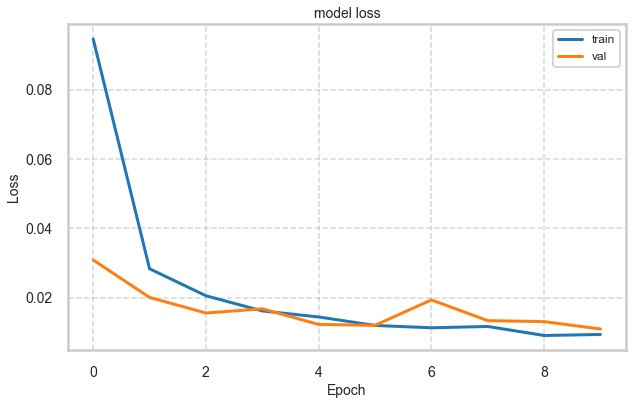

In [592]:
plot_losses()

In [593]:
preds_train = model.predict(X_train_hot)
preds_test = model.predict(X_test_hot)
print_model_scores(y_train, preds_train, y_test, preds_test)

r^2 score on train set is 0.9575
r^2 score on test set is 0.9377
MSE on train set is 0.0069
MSE on test set is 0.0101
rMSE on train set is 0.0831
rMSE on test set is 0.1007


In [636]:
nn_3_200_01_r2_test = 0.9377
nn_3_200_01_MSE_test = 0.0101
nn_3_200_01_rMSE_test = 0.1007
model.save("nn_3_200_01_model.h5")

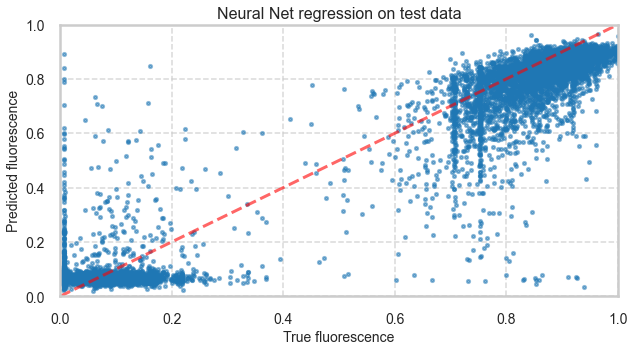

In [595]:
plot_model_prediction_vs_true(y_test, preds_test, title = 'Neural Net regression on test data')

#### Conclusions
* The neural net is predicting GFP brightness much better than the Ridge and XGboost models.
* The model is now accounting for 94% of the variance in the brightnesses.
* It has an MSE on the test set of 0.0101, and rMSE of 0.1007
* The above plot indicates that still there are many instances in the test set not well predicted by the model, particularly many dark GFPs that are not predicted to be dark.

### Trying a neural network with an embedding layer
As discussed above, an amino acid representation other than one-hot emcoding that uses some embedding that implicitly carries some information about the character of the amino acids may improve model performance. To test whether this is the case, I have below built a neural network similar to the one above but now with a first layer that is a keras embedding layer. This layer is meant to learn useful embeddings as the model is trained.

In [1158]:
# Function for Building a Neural Net with an embedding layer
def build_nn_model_embed(dim_embed, num_hidden, width_hidden, drop_rate=drop_rate, learning_rate=learning_rate):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=20, output_dim=dim_embed, input_length=238))
    model.add(tf.keras.layers.Flatten())
    for i in range(num_hidden):
        model.add(tf.keras.layers.Dense(width_hidden, activation = 'relu'))
        model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics = ['mse'])
    model.summary()                               
    return model   

In [1159]:
# Defining Model Hyperparameters
num_hidden = 3
width_hidden = 200
dim_embed = 20
drop_rate = 0.1
batch_size = 32
epochs = 100
learning_rate = 0.00001

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, verbose=1)]

In [611]:
# Building a Neural Net
model = build_nn_model_embed(dim_embed, num_hidden, width_hidden, drop_rate, learning_rate)  

Model: "sequential_567"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 238, 20)           400       
_________________________________________________________________
flatten_18 (Flatten)         (None, 4760)              0         
_________________________________________________________________
dense_2773 (Dense)           (None, 200)               952200    
_________________________________________________________________
dropout_1634 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2774 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1635 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2775 (Dense)           (None, 200)            

In [612]:
# Fitting the NN to the training data, using the valid data for validation
history = model.fit(X_train_int, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid_int, y_valid),
          callbacks=callbacks,
          shuffle=True)

Epoch 1/100
983/983 [==============================] - 3s 3ms/step - loss: 0.1764 - mse: 0.1764 - val_loss: 0.1590 - val_mse: 0.1590
Epoch 2/100
983/983 [==============================] - 3s 3ms/step - loss: 0.1608 - mse: 0.1608 - val_loss: 0.1562 - val_mse: 0.1562
Epoch 3/100
983/983 [==============================] - 3s 3ms/step - loss: 0.1565 - mse: 0.1565 - val_loss: 0.1477 - val_mse: 0.1477
Epoch 4/100
983/983 [==============================] - 3s 3ms/step - loss: 0.1457 - mse: 0.1457 - val_loss: 0.1315 - val_mse: 0.1315
Epoch 5/100
983/983 [==============================] - 3s 3ms/step - loss: 0.1258 - mse: 0.1258 - val_loss: 0.1033 - val_mse: 0.1033
Epoch 6/100
983/983 [==============================] - 3s 3ms/step - loss: 0.0986 - mse: 0.0986 - val_loss: 0.0811 - val_mse: 0.0811
Epoch 7/100
983/983 [==============================] - 3s 3ms/step - loss: 0.0799 - mse: 0.0799 - val_loss: 0.0665 - val_mse: 0.0665
Epoch 8/100
983/983 [==============================] - 3s 3ms/step - 

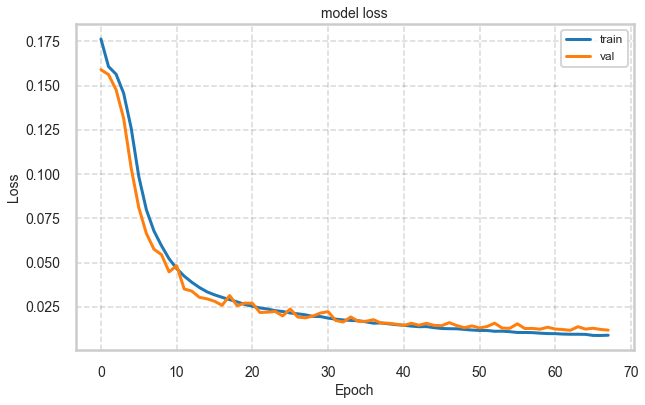

In [613]:
plot_losses()

In [614]:
preds_train = model.predict(X_train_int)
preds_test = model.predict(X_test_int)
print_model_scores(y_train, preds_train, y_test, preds_test)

r^2 score on train set is 0.9623
r^2 score on test set is 0.9296
MSE on train set is 0.0061
MSE on test set is 0.0115
rMSE on train set is 0.0784
rMSE on test set is 0.1071


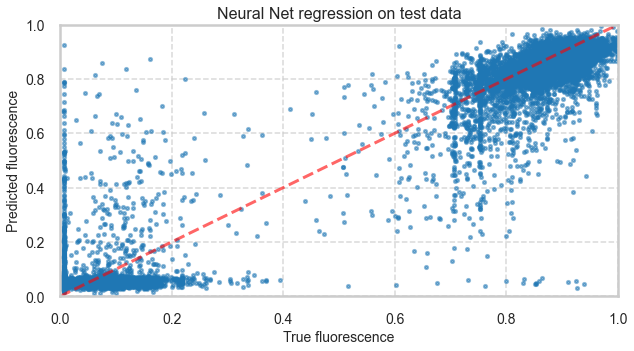

In [615]:
plot_model_prediction_vs_true(y_test, preds_test, title = 'Neural Net regression on test data')

#### Saving model

In [616]:
model.save("nn_3_embed20_200_01.h5")

#### Conclusions
* Adding an embedding layer of 20 neurons did not improve the neural network model, its metrics are nearly the same as the model above without it. However, the plot above suggests that this model is less prone to under-predict at high brightness than the previous one.
* Similar results were also observed for a larger embedding layer of 50 neurons (not shown).
* With the embedding layer present the network needed to be trained with a smaller learning rate.

### Adding inputs to the neural network indicating hydrophobicity and amino-acid volume
Rather than embeddings that must learn about the amio acids on there own, perhaps the neural network model would be improved by giving it information about each amino acid directly. To do this,  I have below built a new neural network that takes in for each amino acid, its one-hot encoding, its Kyte and Doolittle hydrophocity score, and its volume. These input are concatenated and then fed into the network.

#### Building data sets with hydrophobicity and volume

In [617]:
# List for conversion dicts
amino_acids = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'V', 'Y']
hydrophobicity = [1.8, -4.5, -3.5, -3.5, 2.5, -3.5, -3.5, -0.4, -3.2, 4.5, 3.8, -3.9, 1.9, 2.8, -1.6, -0.8, -0.7, -0.9, 4.2, -1.3]
volume = [88.6, 173.4, 114.1, 111.1, 108.5, 138.4, 143.8, 60.1, 153.2, 166.7, 166.7, 168.6, 162.9, 189.9, 112.7, 89.0, 116.1, 227.8, 140.0, 193.6]

In [618]:
# Conversion dictionaries from amino acids to hydrophobicities or volumes

# Dictionary maping amino acid to hydrophobicity
aa_to_hydro ={}
for a, h in zip(amino_acids, hydrophobicity):
    aa_to_hydro[a] = h

# Dictionary maping amino acid to volume
aa_to_vol ={}
for a, v in zip(amino_acids, volume):
    aa_to_vol[a] = v

In [619]:
# Conversion functions from amino acids to hydrophobicities or volumes

# Amino acid to hydrophobicity single sequence
def convert_seq_aa_to_hydro(seq, conversion_dict_aa_to_hydro):
    return [conversion_dict_aa_to_hydro[s] for s in seq]

# Amino acid to volume single sequence
def convert_seq_aa_to_vol(seq, conversion_dict_aa_to_vol):
    return [conversion_dict_aa_to_vol[s] for s in seq]

# Amino acid to hydrophobicity list of sequences 
def convert_seq_list_aa_to_hydro(seq_list, conversion_dict_aa_to_hydro):
    return np.array([convert_seq_aa_to_hydro(seq, conversion_dict_aa_to_hydro) for seq in seq_list])

# Amino acid to volume list of sequences 
def convert_seq_list_aa_to_vol(seq_list, conversion_dict_aa_to_vol):
    return np.array([convert_seq_aa_to_vol(seq, conversion_dict_aa_to_vol) for seq in seq_list])

In [620]:
# Converting X_train, X_valid and X_test to hydrophobicities
X_train_hydro = convert_seq_list_aa_to_hydro(X_train, aa_to_hydro)
X_valid_hydro = convert_seq_list_aa_to_hydro(X_valid, aa_to_hydro)
X_test_hydro = convert_seq_list_aa_to_hydro(X_test, aa_to_hydro)

In [621]:
# Converting X_train, X_valid and X_test to aa volumes
X_train_vol = convert_seq_list_aa_to_vol(X_train, aa_to_vol)
X_valid_vol = convert_seq_list_aa_to_vol(X_valid, aa_to_vol)
X_test_vol = convert_seq_list_aa_to_vol(X_test, aa_to_vol)

In [622]:
X_train_vol

array([[162.9,  89. , 168.6, ..., 166.7, 193.6, 168.6],
       [162.9,  89. , 168.6, ..., 166.7, 193.6, 168.6],
       [162.9,  89. , 168.6, ..., 166.7, 193.6, 168.6],
       ...,
       [162.9,  89. , 168.6, ..., 173.4, 193.6, 168.6],
       [162.9,  89. , 168.6, ..., 166.7, 193.6, 168.6],
       [162.9,  89. , 168.6, ..., 166.7, 193.6, 168.6]])

In [623]:
X_train_hydro

array([[ 1.9, -0.8, -3.9, ...,  3.8, -1.3, -3.9],
       [ 1.9, -0.8, -3.9, ...,  3.8, -1.3, -3.9],
       [ 1.9, -0.8, -3.9, ...,  3.8, -1.3, -3.9],
       ...,
       [ 1.9, -0.8, -3.9, ..., -4.5, -1.3, -3.9],
       [ 1.9, -0.8, -3.9, ...,  3.8, -1.3, -3.9],
       [ 1.9, -0.8, -3.9, ...,  3.8, -1.3, -3.9]])

#### Making a neural network with 3 inputs sequence, hydrophobicity, and volume.

In [640]:
# Making a Model with 3 inputs 
input_aa = tf.keras.Input(shape=(238*20)) # one-hot encoding
input_hydro = tf.keras.Input(shape=(238)) # hydrophobicity
input_vol = tf.keras.Input(shape=(238)) # volume
input_all = tf.keras.layers.Concatenate()([input_aa, input_hydro, input_vol])
x = tf.keras.layers.Dense(300, activation = 'relu')(input_all)
x = tf.keras.layers.Dense(200, activation = 'relu')(x)
x = tf.keras.layers.Dense(200, activation = 'relu')(x)
out = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.models.Model(inputs=[input_aa,input_hydro,input_vol], outputs = out)

model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics = ['mse'])
model.summary()                               



Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 4760)]       0                                            
__________________________________________________________________________________________________
input_50 (InputLayer)           [(None, 238)]        0                                            
__________________________________________________________________________________________________
input_51 (InputLayer)           [(None, 238)]        0                                            
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 5236)         0           input_49[0][0]                   
                                                                 input_50[0][0]       

In [641]:
# Defining Model Hyperparameters

batch_size = 32
epochs = 100
learning_rate = 0.000001

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, verbose=1)]


# Fitting the model
history = model.fit([X_train_hot, X_train_hydro, X_train_vol], y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks, 
          validation_data=([X_valid_hot, X_valid_hydro, X_valid_vol], y_valid),
          shuffle=True)

Epoch 1/100
983/983 [==============================] - 5s 5ms/step - loss: 0.8718 - mse: 0.8718 - val_loss: 0.6032 - val_mse: 0.6032
Epoch 2/100
983/983 [==============================] - 5s 6ms/step - loss: 0.5744 - mse: 0.5744 - val_loss: 0.5245 - val_mse: 0.5245
Epoch 3/100
983/983 [==============================] - 5s 5ms/step - loss: 0.5160 - mse: 0.5160 - val_loss: 0.5263 - val_mse: 0.5263
Epoch 4/100
983/983 [==============================] - 4s 5ms/step - loss: 0.4748 - mse: 0.4748 - val_loss: 0.4506 - val_mse: 0.4506
Epoch 5/100
983/983 [==============================] - 5s 5ms/step - loss: 0.4459 - mse: 0.4459 - val_loss: 0.4276 - val_mse: 0.4276
Epoch 6/100
983/983 [==============================] - 4s 5ms/step - loss: 0.4208 - mse: 0.4208 - val_loss: 0.4205 - val_mse: 0.4205
Epoch 7/100
983/983 [==============================] - 4s 5ms/step - loss: 0.3972 - mse: 0.3972 - val_loss: 0.4082 - val_mse: 0.4082
Epoch 8/100
983/983 [==============================] - 4s 5ms/step - 

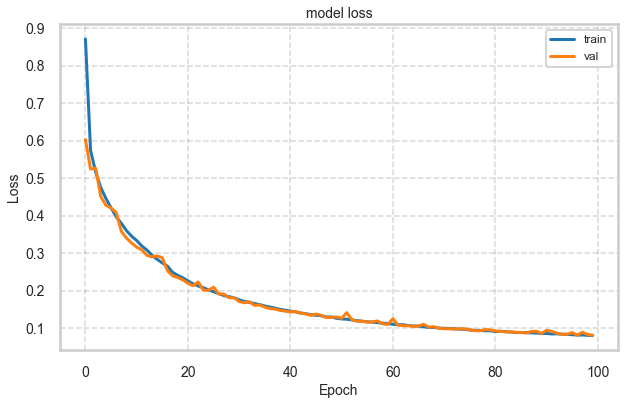

In [642]:
plot_losses()

In [643]:
preds_train = model.predict([X_train_hot, X_train_hydro, X_train_vol])
preds_test = model.predict([X_test_hot, X_test_hydro, X_test_vol])
print_model_scores(y_train, preds_train, y_test, preds_test)

r^2 score on train set is 0.5193
r^2 score on test set is 0.4980
MSE on train set is 0.0782
MSE on test set is 0.0818
rMSE on train set is 0.2797
rMSE on test set is 0.2859


#### Conclusions
* I have not been able to get this model with the extra inputs to predict fluorescence intensity as well as the one without them. This seems strange to me, as in principal more information should not hurt the model. However, it is more diffciult to train this model. It requires a much smaller learnig rate, so perhaps a different architecture would work better. I have not persued this further.

## Two-stage classification then regression predicting
Given that many dead GFPs are evident in the distribution of GFP brightness, perhaps a good approach to predicting fluorescence intensities for this type of data would be to do it in two stages. 
* First, use a classifier to decide if the input sequence is likely to be a dead GFP, and if it is assign it an intensity of 0. 
* Second, use a regression model to predict the flurescence intensities of the remaining "live" GFPS. 

I have implemented this two-stage approach below using one neural network as a binary classifier (dead or alive), and another, as before, as a regressor to predict intensities.

### Building a binary classifier neural network to identify dead GFP
I will adopt a similar structure to that found to be optimal for regression earlier but for the following.
* Its output will be a binary classification (sigmoid activation on a single unit).
* A binary crossentropy loss will be used.
* To compensate for the imbalance in classes (many more live than dead by a factor of ~ 3.6) sample_weighting of the training data that favors dead GFPS will be used.
* The classification metrics recall, precision, and accuracy will be assessed.


#### Preparing data for binary classification, dead or alive

In [794]:
# Adding a column to the dataframe to indicate brightness level(dead, low, high)
idx_dead = df_as_list.index[(df_as_list['Fluorescence'] <= 0.02)]
idx_live = df_as_list.index[(df_as_list['Fluorescence'] > 0.02)]
df_as_list['Dead_level'] = list(range(49129))
df_as_list['Dead_level'][idx_dead] = 'dead'
df_as_list['Dead_level'][idx_live] = 'live'

In [751]:
df_as_list_with_dead_live= pd.get_dummies(df_as_list, columns=['Dead_level'], prefix='class', drop_first=False)
df_as_list_with_dead_live

,Sequence,Fluorescence,Brightness_level,class_dead,class_live
0,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",0.872667,high,0,1
1,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",0.102247,low,0,1
2,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",0.936593,high,0,1
3,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",0.905209,high,0,1
4,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",0.139265,low,0,1
...,...,...,...,...,...
49124,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",1.003250,high,0,1
49125,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",0.039934,low,0,1
49126,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",0.881541,high,0,1
49127,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",0.124493,low,0,1


In [752]:
# Creating Train and test sets (80/20 split)
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(df_as_list_with_dead_live['Sequence'].values,df_as_list_with_dead_live[['class_dead', 'class_live']].values, test_size=0.20, stratify=df_as_list['Brightness_level'], random_state=1)

In [753]:
# Creating Train and Validation sets from the train set
X_train_dl, X_valid_dl, y_train_dl, y_valid_dl = train_test_split(X_train_dl, y_train_dl, test_size=0.20, random_state=1)

In [754]:
# Converting X_train, X_valid and X_test to integer representations
X_train_int_dl = convert_seq_list_aa_to_int(X_train_dl, aa_to_idx)
X_valid_int_dl = convert_seq_list_aa_to_int(X_valid_dl, aa_to_idx)
X_test_int_dl = convert_seq_list_aa_to_int(X_test_dl, aa_to_idx)

In [755]:
# Converting X_train, X_valid and X_test to flat one_hot encoded vectors dim = (-1, 4760)
X_train_hot_dl = to_categorical(X_train_int_dl)
X_train_hot_dl = X_train_hot_dl.reshape(-1, 238*20)
X_valid_hot_dl = to_categorical(X_valid_int_dl)
X_valid_hot_dl = X_valid_hot_dl.reshape(-1, 238*20)
X_test_hot_dl = to_categorical(X_test_int_dl)
X_test_hot_dl = X_test_hot_dl.reshape(-1, 238*20)

# Convert y vectors to 1 dimensional vectors for binary classification
y_test_dl_binary = np.argmax(y_test_dl,axis=1)
y_valid_dl_binary = np.argmax(y_valid_dl,axis=1)
y_train_dl_binary = np.argmax(y_train_dl,axis=1)

#### Function for building a classification network

In [1001]:
 # Function for Building a Neural Net
def build_nn_model_dl(num_hidden, width_hidden, drop_rate=drop_rate, learning_rate=learning_rate):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(width_hidden, activation = 'relu', input_shape=(20*238,)))
    for i in range(num_hidden-1):
        model.add(tf.keras.layers.Dense(width_hidden, activation = 'relu'))
        model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics = metrics)
    model.summary()                               
    return model   

In [1035]:
# defining classification metrics to keep track of
metrics = [ 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')]

In [1041]:
# function to plot metrics after fit
def plot_metrics(history):
    metrics = ['loss', 'precision', 'recall', 'accuracy']
    plt.figure(figsize=(30, 15))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
    plt.legend()

In [1037]:
# Due to class imbalance I will weight the samples in the dead class, with (fraction live)/(fraction dead)
# during the model fitting.
total_num = len(y_train_dl_binary)
num_pos = y_train_dl_binary.sum()
num_negative = total_num - num_pos
weight = num_pos/num_negative 
sample_weights = np.array([1 if i==1 else weight for i in y_train_dl_binary])

#### Building the classifier network and fitting it to the GFP data divided into classifications Dead ( class 0: Flu <=.02) or Live (class 1: Flu > 0.02)

In [1038]:
# Defining Model Hyperparameters
num_hidden = 3
width_hidden = 100
drop_rate = 0.1
batch_size = 32
epochs = 100
learning_rate = 0.0001
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, verbose=1)]

# Building Neural Net
model_c = build_nn_model_dl(num_hidden, width_hidden, drop_rate, learning_rate)

# Fitting the NN to the training data, using the valid data for validation
history = model_c.fit(X_train_hot_dl, y_train_dl_binary,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          #sample_weight = sample_weights, 
          validation_data=(X_valid_hot_dl, y_valid_dl_binary),
          verbose=1,
          shuffle=True)

Model: "sequential_615"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2985 (Dense)           (None, 100)               476100    
_________________________________________________________________
dense_2986 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1731 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_2987 (Dense)           (None, 100)               10100     
_________________________________________________________________
dropout_1732 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_2988 (Dense)           (None, 1)                 101       
Total params: 496,401
Trainable params: 496,401
Non-trainable params: 0
______________________________________________

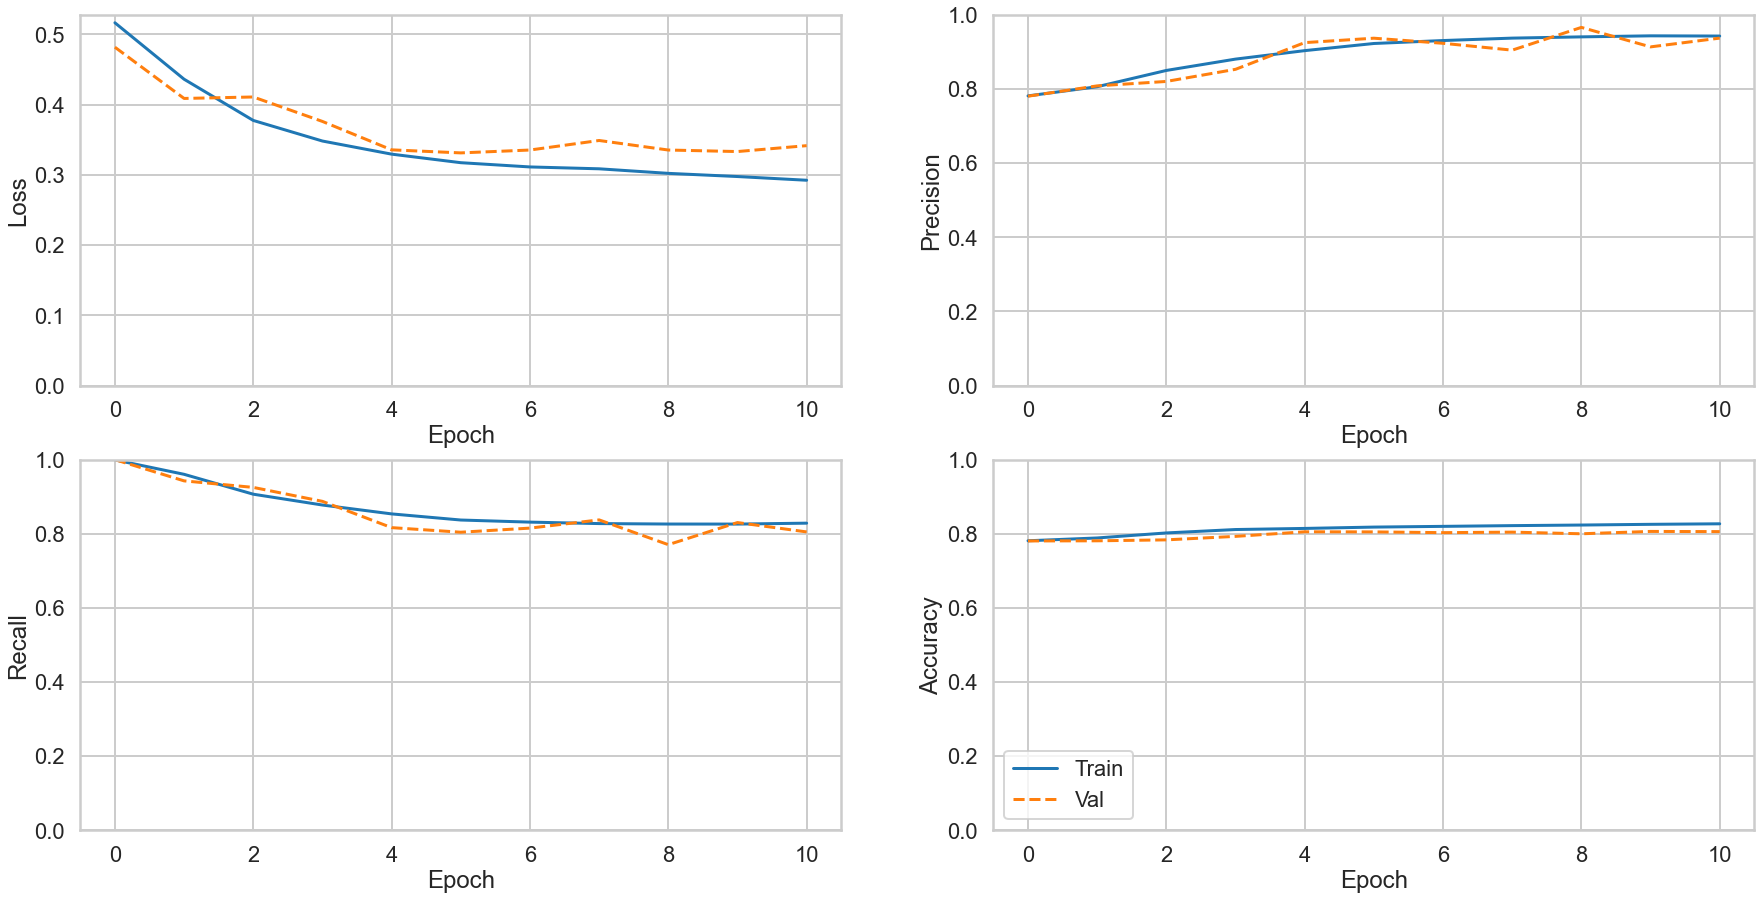

In [1042]:
plot_metrics(history)

In [1043]:
model_c.evaluate(X_test_hot_dl, y_test_dl_binary)

308/308 [==============================] - 0s 806us/step - loss: 0.3462 - accuracy: 0.8081 - precision: 0.9370 - recall: 0.8086 - auc: 0.8684


[0.3462091088294983,
 0.8080602288246155,
 0.9370471239089966,
 0.808624267578125,
 0.868395209312439]

#### Conclusions
* This classifier has an accuracy of 80% on identifying dead GFPs in the test data.
* Its precsion (0.937) indicates it is producing a small fraction of positives that are false (0.063).
* Its recall (0.8086) indicates it is correctly identifying most live GFPS (80%) but some are missed.
* I have played with it without seeing further improvement. Surprisingly, it works slightly better without the sample weighting.
* I will use it to identify dead GFP in the two-stage prediction process.

In [1045]:
nn_3_100_01_classifier = model_c
model.save('nn_3_100_01_classifier.h5')

### Building a new regression model fitted to just live GFP (fluo >0.02)

#### Preparing data with dead GFP excluded

In [1160]:
df_as_list_live = df_as_list_with_dead_live[df_as_list_with_dead_live['class_live']==1]

In [761]:
# Creating Train and test sets (80/20 split)
X_train_live, X_test_live, y_train_live, y_test_live = train_test_split(df_as_list_live['Sequence'].values, df_as_list_live['Fluorescence'].values, test_size=0.20,  random_state=1)

In [762]:
# Creating Train and Validation sets from the train set
X_train_live, X_valid_live, y_train_live, y_valid_live = train_test_split(X_train_live, y_train_live, test_size=0.20, random_state=1)

In [763]:
# Converting X_train, X_valid and X_test to integer representations
X_train_int_live = convert_seq_list_aa_to_int(X_train_live, aa_to_idx)
X_valid_int_live = convert_seq_list_aa_to_int(X_valid_live, aa_to_idx)
X_test_int_live = convert_seq_list_aa_to_int(X_test_live, aa_to_idx)

In [764]:
# Converting X_train, X_valid and X_test to flat one_hot encoded vectors dim = (-1, 4760)
X_train_hot_live = to_categorical(X_train_int_live)
X_train_hot_live = X_train_hot_live.reshape(-1, 238*20)
X_valid_hot_live = to_categorical(X_valid_int_live)
X_valid_hot_live = X_valid_hot_live.reshape(-1, 238*20)
X_test_hot_live = to_categorical(X_test_int_live)
X_test_hot_live = X_test_hot_live.reshape(-1, 238*20)

#### A function for buiding a regression neural network

In [765]:
# Function for Building a Neural Net for regression similar to previous
def build_nn_model_live(num_hidden, width_hidden, drop_rate=drop_rate, learning_rate=learning_rate):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(width_hidden, activation = 'relu', input_shape=(20*238,)))
    for i in range(num_hidden-1):
        model.add(tf.keras.layers.Dense(width_hidden, activation = 'relu'))
        model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics = ['mse'])
    model.summary()                               
    return model   

In [1046]:
# Defining Model Hyperparameters
num_hidden = 3
width_hidden = 200
drop_rate = 0.1
batch_size = 32
epochs = 100
learning_rate = 0.0001
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, verbose=1)]

# Building Neural Net
model_r = build_nn_model_live(num_hidden, width_hidden, drop_rate, learning_rate)

# Fitting the NN to the training data, using the valid data for validation
history = model_r.fit(X_train_hot_live, y_train_live,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=(X_valid_hot_live, y_valid_live),
          shuffle=True)

Model: "sequential_616"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2989 (Dense)           (None, 200)               952200    
_________________________________________________________________
dense_2990 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1733 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2991 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_1734 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_2992 (Dense)           (None, 1)                 201       
Total params: 1,032,801
Trainable params: 1,032,801
Non-trainable params: 0
__________________________________________

In [1053]:
preds_train = model_r.predict(X_train_hot_live)
preds_test = model_r.predict(X_test_hot_live)
print_model_scores(y_train_live, preds_train, y_test_live, preds_test)

r^2 score on train set is 0.9681
r^2 score on test set is 0.9094
MSE on train set is 0.0036
MSE on test set is 0.0101
rMSE on train set is 0.0602
rMSE on test set is 0.1003


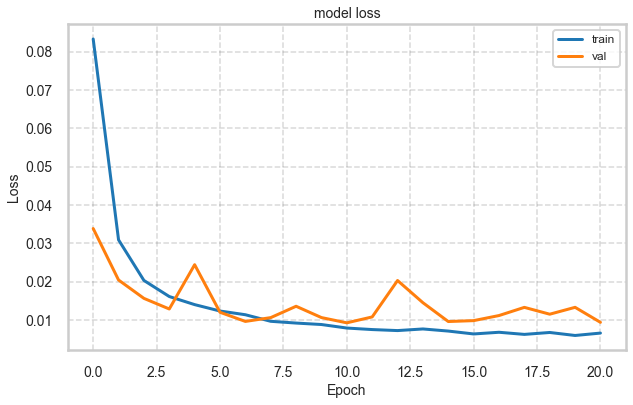

In [1054]:
plot_losses()

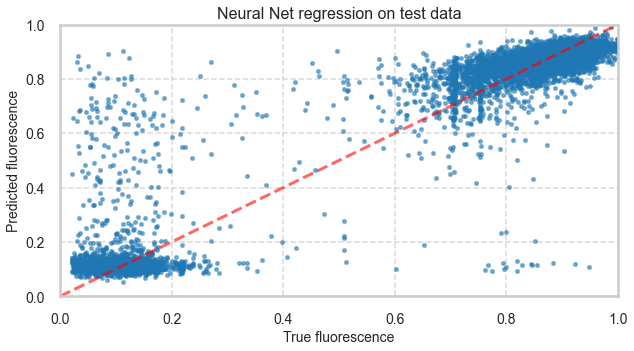

In [1055]:
plot_model_prediction_vs_true(y_test_live, preds_test, title = 'Neural Net regression on test data')

In [1056]:
nn_3_200_01_live = model_r
model_r.save('model_r.h5')

#### Conclusion
* In the absense of the dead GFP (flu < 0.02) the model performs in a manner similar to when the dead GFP were present.
* r^2 score on test set is 0.9094
* MSE on test set is 0.0101
* rMSE on test set is 0.1003


### Testing the two-stage approach
Below is a function that will do the following.
* Take in a test dataframe of GFP sequecnes and fluorescence intensites. 
* With the classifier predict which GFPs are dead and assign them a intensity value of 0.
* With the regressor predict intesnity values for the remaining GFPs.
* Combine the two sets of predictions and evaluate MSE, rMSE and r^2 score for the full test set.

I have applied this procedure to the original test data first generated as X_test and y_test. The results are below.

In [1162]:
def eval_test_df_with_two_stage_model(df_as_list, model_c, r_model_r):
    '''
    Predicts flourescence intensities of a dataframe of GFP instances using a two stage process
        1) Uses model_c to identify dead GFP, assign these GFP a intensity of dead_int_value=0.
        2) Uses model_r to predict intensities for the GFPs predicted to be live.
    
    Input:
        df_as_list: (pandas dataframe) A dataframe with two columns: 'Sequence' and 'Flourescence'.
            The Sequence column contains an amino acid sequence as a string for each instance.
            The Flourescence column contains a scalar intensity for each instance.
            
        c_model: (keras or sklearn model) first stage model for classification
                  of instances into dead or live.
        
        r_model: (keras or sklearn model) second stage model for regression,
                  predicting fluorescence intensity for each live instance.
        
    Returns:
        df: (pandas dataframe) the orginal dataframe with two added columns,
         'pred classes' and 'y_preds', the class (dead or live) and intensity
          predictions for each instance respectively.
        
        r2(float): r2 metric on true and predicted intensities
        mse(float): mean squared error between true and predicted flourescences
        rmse(float): root mean squared error between true and predicted flourescences
    '''
    
    # copy input 
    df = df_as_list.copy()

    # find true live and dead GFPs
    idx_dead = df.index[(df['Fluorescence'] <= 0.02)]
    idx_live = df.index[(df['Fluorescence'] > 0.02)]

    # Make X for classifier (called X_full)
    X_full = df_as_list['Sequence'].values
    y_full = df_as_list['Fluorescence'].values
    X_full_int = convert_seq_list_aa_to_int(X_full, aa_to_idx)
    X_full_hot = to_categorical(X_full_int)
    X_full_hot = X_full_hot.reshape(-1, 238*20)

    # Get class prediction from classifier and add to df
    class_preds = np.round(model_c.predict(X_full_hot))
    df['pred classes'] = class_preds
    idx_pred_dead = df.index[df['pred classes']==0]
    idx_pred_live = df.index[df['pred classes']==1]

    # Make X for regressor
    df_pred_live = df.iloc[idx_pred_live,: ]
    X_live = df_pred_live['Sequence'].values
    X_live_int = convert_seq_list_aa_to_int(X_live, aa_to_idx)
    X_live_hot = to_categorical(X_live_int)
    X_live_hot = X_live_hot.reshape(-1, 238*20)

    # Get predictions on live GFPs from regresison model and add to df
    live_preds = model_r.predict(X_live_hot)
    df['y_preds'] = np.zeros(len(y_full))
    df['y_preds'][list(idx_pred_live)] = list(live_preds.reshape(-1,))
    df['y_preds'][list(idx_pred_dead)] = [0]*len(idx_pred_dead)
    y_preds = df['y_preds'].values

    # calculate and print metrics
    mse = mean_squared_error(y_full , y_preds)
    rmse = mean_squared_error(y_full , y_preds)**0.5
    r2 = r2_score(y_full, y_preds)
    print(f'r^2 = {r2:.4f}')
    print(f'MSE = {mse:.4f}')
    print(f'rMSE = s {rmse:.4f}')
    
    return df, mse, rmse, r2

In [1152]:
# Declare models and data for the two-stage procedure
model_c = nn_3_100_01_classifier
model_r = nn_3_200_01_live 
df_test = pd.DataFrame({'Sequence':X_test, 'Fluorescence':y_test.reshape(-1, )})

In [1154]:
# Apply the two-stage procedure to the test set
df_two_stage, mse_two_stage,rmse_two_stage,r2_two_stage = eval_test_df_with_two_stage_model(df_as_list, 
                                                                nn_3_100_01_classifier, nn_3_200_01_live)

r^2 = 0.9412
MSE = 0.0096
rMSE = s 0.0979


#### Two stage results,  predictions of class and fluo intensity are in the right two columns

In [1155]:
df_two_stage

,Sequence,Fluorescence,Brightness_level,Dead_level,pred classes,y_preds
0,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",0.872667,high,live,1.0,0.870342
1,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",0.102247,low,live,0.0,0.000000
2,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",0.936593,high,live,1.0,0.932413
3,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",0.905209,high,live,1.0,0.851209
4,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",0.139265,low,live,1.0,0.117240
...,...,...,...,...,...,...
49124,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",1.003250,high,live,1.0,0.934433
49125,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",0.039934,low,live,0.0,0.000000
49126,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",0.881541,high,live,1.0,0.884599
49127,"[M, S, K, G, E, E, L, F, T, G, V, V, P, I, L, ...",0.124493,low,live,0.0,0.000000


#### Plotting true fluorescence vs predicted for the two-stage process

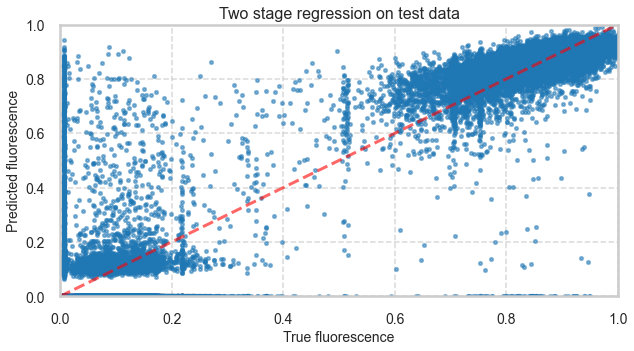

In [1156]:
plot_model_prediction_vs_true(df_two_stage['Fluorescence'], df_two_stage['y_preds'], title = 'Two stage regression on test data')

#### Conclusions:
* The two-stage approach produced the best metrics yet, slightly better than a single neural net (see table below).
* But as is evident in the figure above, still the fluorescence intensities of many GFP are not well predicted and a few hundred dead GFPs evaded the classifier.

## Final Conclusion
Below is a table that summarizes the results of the modeling work I have done here. The two-stage approach worked best followed closely by a single neural net with one-hot encoded inputs. Although these models perfomed much better than a linear ridge model, still they do not capture enough information to make predictions that are as accurate as one would like. If I were to continue this work I would try the follwing:

* 1) Classify the GFPs into 3 categories (dead, low, and high) and then building separate regressors for both the low and high categories.


* 2) Try again to directly add information about amino acid qualities, such as hydrophobicity and volume, with a new architecture that processes each input more before concatenation.


* 3) Try to identify amino acids whose mutation have the most dramatic effects on flourescence intensities (via correlating mutation with intensity) and then building models with input about just those positions.

### Summary Results Table

In [1164]:
# Creating Overall Results Table
models = ['Ridge', 'XGboost', 'NN_one_hot', 'NN_embedding', 'NN_3_inputs', 'Two_stage']
mse = [0.0491, 0.0479, 0.0101, 0.0115, 0.0818, 0.0096]
rmse = [0.2215, 0.2188, 0.1007, 0.1071, 0.2859, 0.0979]
r2 = [0.6987, 0.7062, 0.9377, 0.9296, 0.4980, 0.9412]
results_df = pd.DataFrame({'Model':models, 'MSE':mse, 'rMSE':rmse,'r2': r2 })
results_df

,Model,MSE,rMSE,r2
0,Ridge,0.0491,0.2215,0.6987
1,XGboost,0.0479,0.2188,0.7062
2,NN_one_hot,0.0101,0.1007,0.9377
3,NN_embedding,0.0115,0.1071,0.9296
4,NN_3_inputs,0.0818,0.2859,0.4980
5,Two_stage,0.0096,0.0979,0.9412
